# Project Human Language Technology - OffensEval2019
## roBERTa Base Twitter
This notebook will explore a model for competition "OffensEval 2019: Identifying and Categorizing Offensive Language in Social Media" using roBERTa Base Twitter. \
roBERTa Base is a model trained on ~58M tweets, described and evaluated in the TweetEval benchmark. \
Matricola: 505252 Michele Morisco

In [1]:
import sys
sys.path.insert(1, '../input/hlt-data/Library/')
dataset_path = '../input/olid-dataset/'
glove_path = '../input/glovetwitter27b100dtxt'

In [2]:
#!pip install pytorch-pretrained-bert pytorch-nlp
!pip install emoji --upgrade
!pip install wordsegment
!pip install transformers 
!pip install ekphrasis
!pip install inflect

In [19]:
from PreProcessing import load_dataset
from RoBERTaBase import run_with_kfold, evaluateFinal
from AnalysisGraph import show_confusion_matrix, show_report, showWrongPredictions

In [4]:
import string
string.punctuation
import csv
import pandas as pd
import numpy as np

from transformers import BertForSequenceClassification, BertConfig, RobertaModel, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score
import torch
from torch import tensor
import torch.nn as nn
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import random

#% matplotlib inline

#Random seed initialization for replicability of results
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

import warnings
warnings.filterwarnings("ignore")

In [5]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
    !nvidia-smi
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB
Thu Oct 13 12:01:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    25W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                        

In [6]:
#SET THE PARAMETERS FOR TRAINING 
H_PARAMETERS = {'model_name': 'cardiffnlp/twitter-roberta-base', 'unit_layers' : [768, 64, 32, 2], 'dropout': 0.4, 'folds' : 4, 'batch_size': 8, 
                'warmup_proportion' : 0.1, 'learning_rate': 2e-6, 'loss' : nn.CrossEntropyLoss(), 'num_epochs': 4, 'device' : device}

In [7]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [8]:
#dataset = open("OLID/olid-training-v1.0.tsv")
data, label = load_dataset(dataset_path = dataset_path)

data.subtask_a.value_counts()

Reading english - 1grams ...
Reading english - 2grams ...
Reading english - 1grams ...
user canada need another cuck already enough looney leave liberals fking great country qp roof trudeau must go


NOT    8840
OFF    4400
Name: subtask_a, dtype: int64

In [9]:
data.tweet.sample(20)

12823                     user good antifa violent fascism
12290    user de create slowly stealthily since conserv...
8474     christian kabasele reveal secrets behind watfo...
4676     user oppose neutral jurist sit scotus weigh me...
397      user wonder apologize diamond silk call minstr...
10957    user know canada want seem enough problems lib...
3311                                        user love maga
12936    user agree still conservatives heart may hate ...
8575                         play water slider summer http
4392     kyky u love u anfield putain la cliiimmmm liv psg
7673     user compromise active investigation sound lik...
12966    fill sky chemicals frequencies ido consent con...
12215    love one another starlight darkness surround m...
5480     verge collapse break wave cannot explain whole...
3535                user hair polyester fibers yoda puppet
4425                           user first regression laugh
5523     user well brandon conservatives get elect red .

In [10]:
X_train = list(data.tweet.values)

In [11]:
MAX_SEQ_LENGTH = 64

tokenizer = RobertaTokenizer.from_pretrained(H_PARAMETERS['model_name'], do_lower_case=True)
sentences = data.tweet.values
tokens = tokenizer(X_train, padding=True, truncation=True, max_length=MAX_SEQ_LENGTH)

# Create input ids
input_ids = []
# Create attention masks
attention_masks = []

input_ids_train = torch.tensor(tokens['input_ids'])
attention_masks_train  = torch.tensor(tokens['attention_mask'])

In [12]:
print('Original: ', sentences[0])
print('Token IDs:', input_ids_train[0])

Original:  user ask native americans take
Token IDs: tensor([    0, 12105,  1394,  3763, 38187,  1253,   185,     2,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1])


In [13]:
loss_fn = nn.CrossEntropyLoss()

In [14]:
test_data, label_test = load_dataset(dataset_path = dataset_path, dataset='testset-levela.tsv', dataset_label='labels-levela.csv')
X_test = list(test_data.tweet.values)

Reading english - 1grams ...
Reading english - 2grams ...
Reading english - 1grams ...
bigg boss tamil janani task go first final listclapping hand clap hand clap hand clap hand


In [15]:
tokens = tokenizer(X_test, padding=True, truncation=True, max_length=MAX_SEQ_LENGTH)

# Create input ids
input_ids = []
# Create attention masks
attention_masks = []

input_ids_test = torch.tensor(tokens['input_ids'])
attention_masks_test  = torch.tensor(tokens['attention_mask'])

test_dataset = TensorDataset(input_ids_test, attention_masks_test, torch.tensor(label_test))
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=len(test_dataset))

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sequential(
  (0): Linear(in_features=768, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.4, inplace=False)
  (6): Linear(in_features=32, out_features=2, bias=True)
)
Start training...

 Epoch  |  Batch  |  Train Loss  | F1 Train  |  Val Loss  |  Val Acc  |  F1 Val   |  Elapsed 
-----------------------------------------------------------------------------------------------
   1    |   20    |   0.712129   |   0.29    |     -      |     -     |     -     |   1.98   
   1    |   40    |   0.713062   |   0.27    |     -      |     -     |     -     |   1.65   
   1    |   60    |   0.709727   |   0.34    |     -      |     -     |     -     |   1.65   
   1    |   80    |   0.708742   |   0.34    |     -      |     -     |     -     |   1.65   
   1    |   100   |   0.701684   |   0.37    |     -      |     -     |     -     |   1.66   
   1    |   120   |   0.703027 

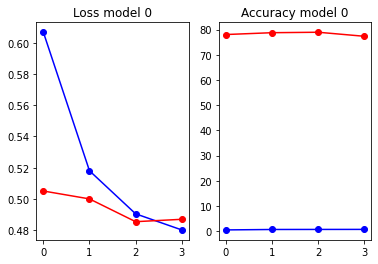

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sequential(
  (0): Linear(in_features=768, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.4, inplace=False)
  (6): Linear(in_features=32, out_features=2, bias=True)
)
Start training...

 Epoch  |  Batch  |  Train Loss  | F1 Train  |  Val Loss  |  Val Acc  |  F1 Val   |  Elapsed 
-----------------------------------------------------------------------------------------------
   1    |   20    |   0.680473   |   0.43    |     -      |     -     |     -     |   1.76   
   1    |   40    |   0.673590   |   0.48    |     -      |     -     |     -     |   1.66   
   1    |   60    |   0.679535   |   0.44    |     -      |     -     |     -     |   1.66   
   1    |   80    |   0.672562   |   0.45    |     -      |     -     |     -     |   1.65   
   1    |   100   |   0.675439   |   0.43    |     -      |     -     |     -     |   1.66   
   1    |   120   |   0.669830 

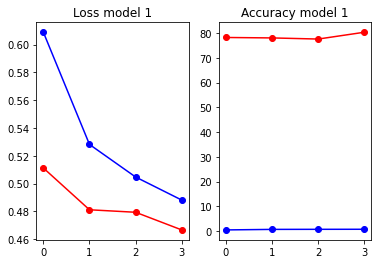

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sequential(
  (0): Linear(in_features=768, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.4, inplace=False)
  (6): Linear(in_features=32, out_features=2, bias=True)
)
Start training...

 Epoch  |  Batch  |  Train Loss  | F1 Train  |  Val Loss  |  Val Acc  |  F1 Val   |  Elapsed 
-----------------------------------------------------------------------------------------------
   1    |   20    |   0.676529   |   0.45    |     -      |     -     |     -     |   1.75   
   1    |   40    |   0.678478   |   0.43    |     -      |     -     |     -     |   1.70   
   1    |   60    |   0.675624   |   0.44    |     -      |     -     |     -     |   1.68   
   1    |   80    |   0.677479   |   0.44    |     -      |     -     |     -     |   1.66   
   1    |   100   |   0.669938   |   0.38    |     -      |     -     |     -     |   1.66   
   1    |   120   |   0.662238 

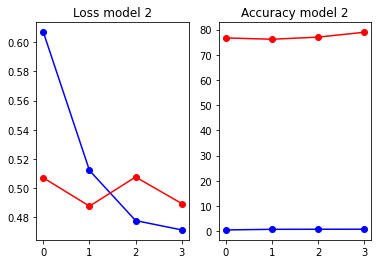

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sequential(
  (0): Linear(in_features=768, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.4, inplace=False)
  (6): Linear(in_features=32, out_features=2, bias=True)
)
Start training...

 Epoch  |  Batch  |  Train Loss  | F1 Train  |  Val Loss  |  Val Acc  |  F1 Val   |  Elapsed 
-----------------------------------------------------------------------------------------------
   1    |   20    |   0.648226   |   0.45    |     -      |     -     |     -     |   1.75   
   1    |   40    |   0.663639   |   0.39    |     -      |     -     |     -     |   1.66   
   1    |   60    |   0.652145   |   0.40    |     -      |     -     |     -     |   1.66   
   1    |   80    |   0.650882   |   0.42    |     -      |     -     |     -     |   1.66   
   1    |   100   |   0.664047   |   0.41    |     -      |     -     |     -     |   1.90   
   1    |   120   |   0.635543 

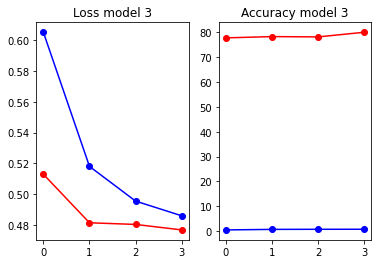

------RESULT------


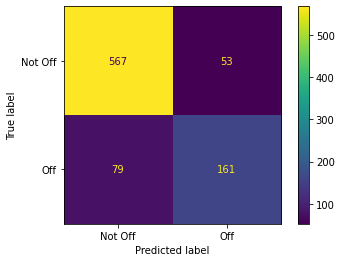

              precision    recall  f1-score   support

     Not Off     0.8777    0.9145    0.8957       620
         Off     0.7523    0.6708    0.7093       240

    accuracy                         0.8465       860
   macro avg     0.8150    0.7927    0.8025       860
weighted avg     0.8427    0.8465    0.8437       860

f1_score test tweets: 0.802492849238992


In [16]:
models, preds_ensemble = run_with_kfold(input_ids_train, attention_masks_train, test_dataloader, torch.tensor(label), label_test, H_PARAMETERS)

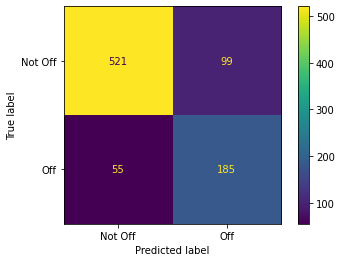

              precision    recall  f1-score   support

     Not Off     0.9045    0.8403    0.8712       620
         Off     0.6514    0.7708    0.7061       240

    accuracy                         0.8209       860
   macro avg     0.7780    0.8056    0.7887       860
weighted avg     0.8339    0.8209    0.8252       860

Bert model 0 tweets testset result => Loss: 0.39749038219451904 Accuracy: 82.09302325581396 F1 score: 78.86721642114938


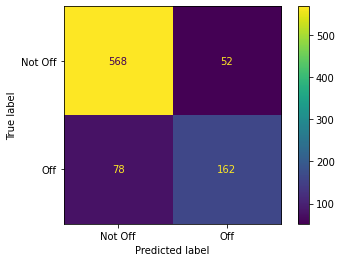

              precision    recall  f1-score   support

     Not Off     0.8793    0.9161    0.8973       620
         Off     0.7570    0.6750    0.7137       240

    accuracy                         0.8488       860
   macro avg     0.8181    0.7956    0.8055       860
weighted avg     0.8451    0.8488    0.8461       860

Bert model 1 tweets testset result => Loss: 0.3862340748310089 Accuracy: 84.88372093023256 F1 score: 80.548538182628


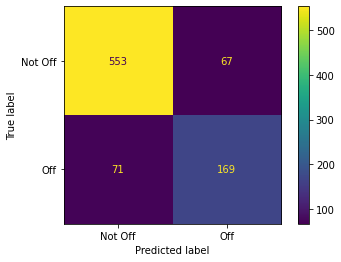

              precision    recall  f1-score   support

     Not Off     0.8862    0.8919    0.8891       620
         Off     0.7161    0.7042    0.7101       240

    accuracy                         0.8395       860
   macro avg     0.8012    0.7981    0.7996       860
weighted avg     0.8387    0.8395    0.8391       860

Bert model 2 tweets testset result => Loss: 0.38590747117996216 Accuracy: 83.95348837209302 F1 score: 79.95757788646006


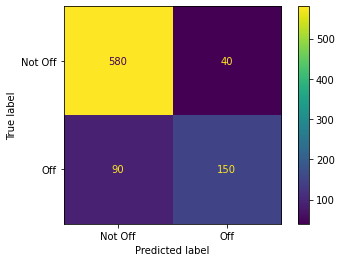

              precision    recall  f1-score   support

     Not Off     0.8657    0.9355    0.8992       620
         Off     0.7895    0.6250    0.6977       240

    accuracy                         0.8488       860
   macro avg     0.8276    0.7802    0.7984       860
weighted avg     0.8444    0.8488    0.8430       860

Bert model 3 tweets testset result => Loss: 0.3988887071609497 Accuracy: 84.88372093023256 F1 score: 79.84496124031007


In [17]:
for i in range(len(models)):
  models[i].to(device)
  val_loss, val_accuracys, f1_value_tweets = evaluateFinal(models[i], test_dataloader, H_PARAMETERS['device'], H_PARAMETERS['loss'])
  models[i].to('cpu')
  print("Bert model {0} tweets testset result => Loss: {1} Accuracy: {2} F1 score: {3}".format(i, val_loss, val_accuracys, f1_value_tweets))

In [20]:
showWrongPredictions(test_data, torch.tensor(label), preds_ensemble)

       id                   tweet
14  12588  user nigga ware da hit
       id                                   tweet
15  34263  stop kavanaugh liar like rest gop http
       id                                              tweet
21  70840  kavanaugh wild claim number years ago grope ev...
       id                                              tweet
27  49139  user put delauro police lineup identify bag la...
       id                                              tweet
38  46444  ariana asesina serious holy shit please fuck a...
      id                                              tweet
1  27014  constitution day revere conservatives hat prog...
      id                                              tweet
3  13876  watch boomer get news still parole always make...
      id                                              tweet
6  96874  rap form art use express freely gv green light...
      id                                              tweet
9  46363  bigg boss tamil janani task go first